<a href="https://colab.research.google.com/github/AnkushJamthikar/ConceptsInAI/blob/main/GAN_forSynetheticData_BCdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import randn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
data = pd.read_csv('/content/diabetes.csv')
print (data.shape)
print (data.tail())
print (data.columns)

(768, 9)
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [3]:
features  = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
label     = ['Outcome']
X         = data[features]
y         = data[label]

In [4]:
X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [5]:
clf_true = RandomForestClassifier(n_estimators=100)
clf_true.fit(X_true_train,y_true_train)
y_true_pred=clf_true.predict(X_true_test)
print("Base Accuracy:",metrics.accuracy_score(y_true_test, y_true_pred))
print("Base classification report:",metrics.classification_report(y_true_test, y_true_pred))

<ipython-input-5-55efe8668831>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_true.fit(X_true_train,y_true_train)


Base Accuracy: 0.7402597402597403
Base classification report:               precision    recall  f1-score   support

           0       0.81      0.79      0.80       151
           1       0.62      0.64      0.63        80

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.74      0.74       231



In [6]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [7]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))

    return X, y

In [8]:
# generate n real samples with class labels; We randomly select n samples from the real data
def generate_real_samples(n):
    X = data.sample(n)
    y = np.ones((n, 1))
    return X, y

In [9]:
def define_generator(latent_dim, n_outputs=9):
    model = Sequential()
    model.add(Dense(15, activation='relu',  kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [10]:
generator1 = define_generator(10, 9)
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 9)                 279       
                                                                 
Total params: 924 (3.61 KB)
Trainable params: 924 (3.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
def define_discriminator(n_inputs=9):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [12]:
discriminator1 = define_discriminator(9)
discriminator1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                250       
                                                                 
 dense_4 (Dense)             (None, 50)                1300      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1601 (6.25 KB)
Trainable params: 1601 (6.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [14]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [15]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    # plot loss
    plt.subplot(1, 1, 1)
    plt.plot(d_hist, label='d')
    plt.plot(g_hist, label='gen')
    plt.show()
    plt.close()

In [16]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the  discriminator
    half_batch  = int(n_batch / 2)
    d_history   = []
    g_history   = []
    # manually enumerate epochs
    for epoch in range(n_epochs):

      # prepare real samples
      x_real, y_real = generate_real_samples(half_batch)
      # prepare fake examples
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator
      d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
      d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      # prepare points in latent space as input for the generator
      x_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
      print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
      d_history.append(d_loss)
      g_history.append(g_loss_fake)
    plot_history(d_history, g_history)
    g_model.save('trained_generated_model.h5')

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
>7501, d1=0.551, d2=0.216 d=0.384 g=2.085
2/2 [==============================] - 0s 4ms/step
>7502, d1=0.390, d2=0.352 d=0.371 g=1.657
2/2 [==============================] - 0s 6ms/step
>7503, d1=0.283, d2=0.436 d=0.359 g=1.570
2/2 [==============================] - 0s 12ms/step
>7504, d1=0.191, d2=0.480 d=0.336 g=1.938
2/2 [==============================] - 0s 5ms/step
>7505, d1=0.410, d2=0.221 d=0.315 g=2.469
2/2 [==============================] - 0s 5ms/step
>7506, d1=0.411, d2=0.169 d=0.290 g=2.330
2/2 [==============================] - 0s 3ms/step
>7507, d1=0.414, d2=0.314 d=0.364 g=1.755
2/2 [==============================] - 0s 7ms/step
>7508, d1=0.301, d2=0.420 d=0.360 g=1.587
2/2 [==============================] - 0s 7ms/step
>7509, d1=0.181, d2=0.401 d=0.291 g=1.859
2/2 [==============================] - 0s 4ms/step
>7510, d1=0.343, d2=0.270 d=0.306 g=2.044
2/2 [=============

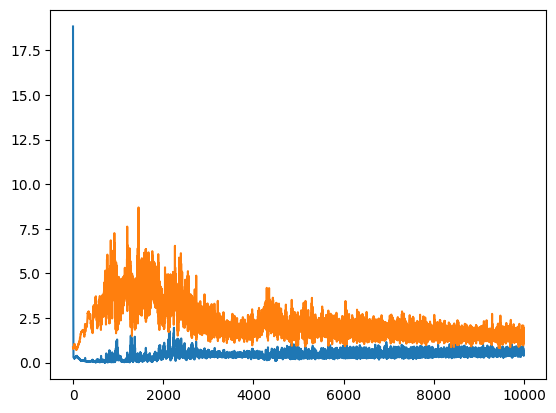

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [16]:
from keras.models import load_model
model =load_model('/content/trained_generated_model.h5')

In [17]:
latent_points = generate_latent_points(10, 750)
X = model.predict(latent_points)
data_fake = pd.DataFrame(data=X,  columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])
data_fake.head()

24/24 [==============================] - 2s 5ms/step


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2.674857,43.649010,38.776577,0.805825,-0.314200,18.675123,0.675153,23.759827,0.156819
1,4.002524,92.574203,45.458984,16.276583,102.280212,16.937840,0.066467,21.666399,0.321012
2,17.447266,231.938660,151.493759,64.684296,-2.910693,77.373825,1.440677,78.332146,1.718230
3,4.842126,214.080368,153.571503,50.227337,-1.649764,50.626793,1.263496,47.816860,0.111385
4,5.798978,265.003082,194.142944,93.245872,0.792250,103.135643,2.484663,58.375732,-0.170754


In [18]:
outcome_mean = data_fake.Outcome.mean()
data_fake['Outcome'] = data_fake['Outcome'] > outcome_mean
data_fake["Outcome"] = data_fake["Outcome"].astype(int)

In [19]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
label = ['Outcome']
X_fake_created = data_fake[features]
y_fake_created = data_fake[label]


In [20]:
X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake_created, y_fake_created, test_size=0.30, random_state=42)
clf_fake = RandomForestClassifier(n_estimators=100)
clf_fake.fit(X_fake_train,y_fake_train)
y_fake_pred=clf_fake.predict(X_fake_test)
print("Accuracy of fake data model:",metrics.accuracy_score(y_fake_test, y_fake_pred))
print("Classification report of fake data model:",metrics.classification_report(y_fake_test, y_fake_pred))

<ipython-input-20-540994085c86>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_fake.fit(X_fake_train,y_fake_train)


Accuracy of fake data model: 0.9022222222222223
Classification report of fake data model:               precision    recall  f1-score   support

           0       0.89      0.96      0.93       141
           1       0.93      0.80      0.86        84

    accuracy                           0.90       225
   macro avg       0.91      0.88      0.89       225
weighted avg       0.90      0.90      0.90       225



In [30]:
!pip install table_evaluator


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 42.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.


In [21]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(data, data_fake)
table_evaluator.evaluate(target_col='Outcome')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7133   0.8867              0.5625
DecisionTreeClassifier_real   0.7933   0.6200              0.4563
LogisticRegression_fake       0.7267   0.9200              0.6393
LogisticRegression_real       0.7600   0.6400              0.5306
MLPClassifier_fake            0.7333   0.9400              0.5385
MLPClassifier_real            0.7667   0.5800              0.5306
RandomForestClassifier_fake   0.6733   0.9000              0.5789
RandomForestClassifier_real   0.7467   0.6933              0.6304

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.5259
nearest neighbor std                     0.7139

Miscellaneous results:
                                  Result
Column Cor

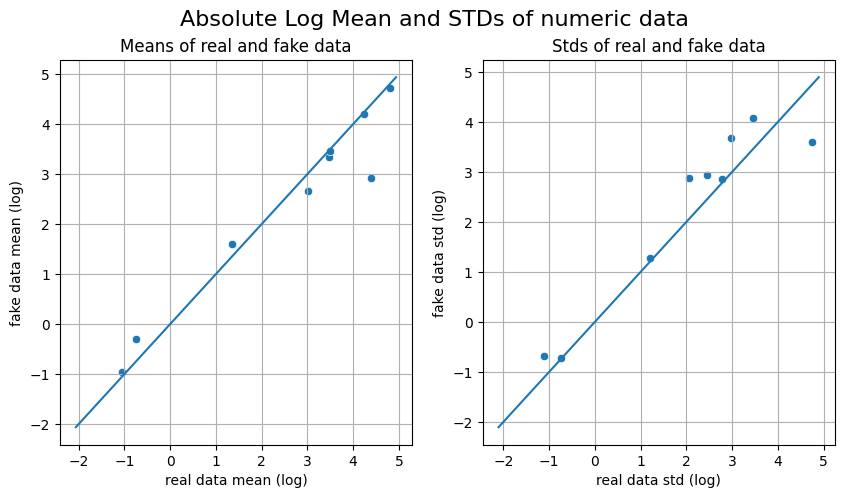

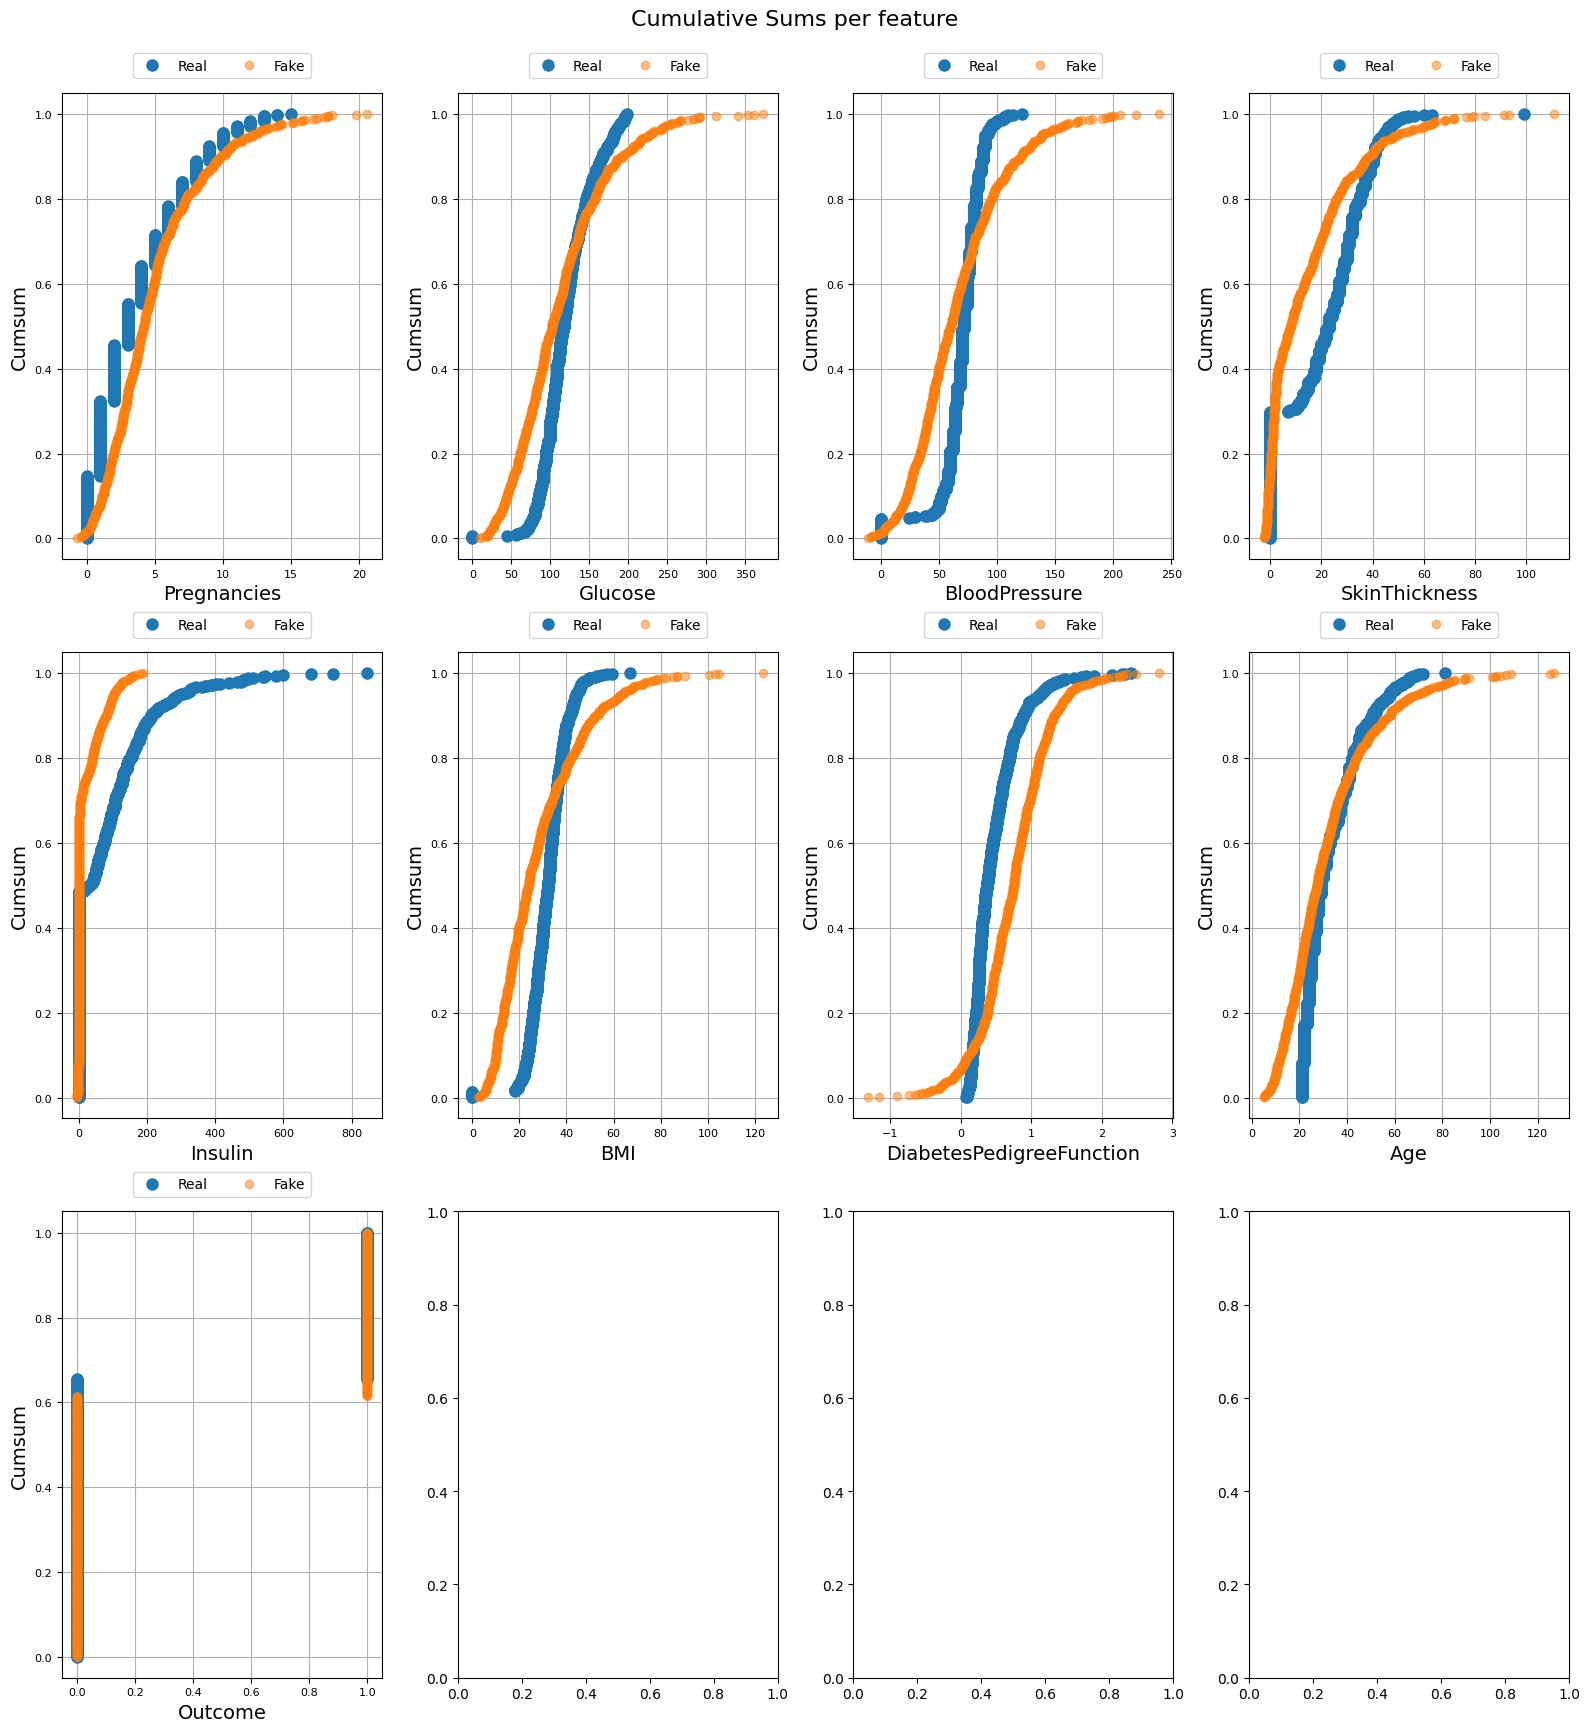

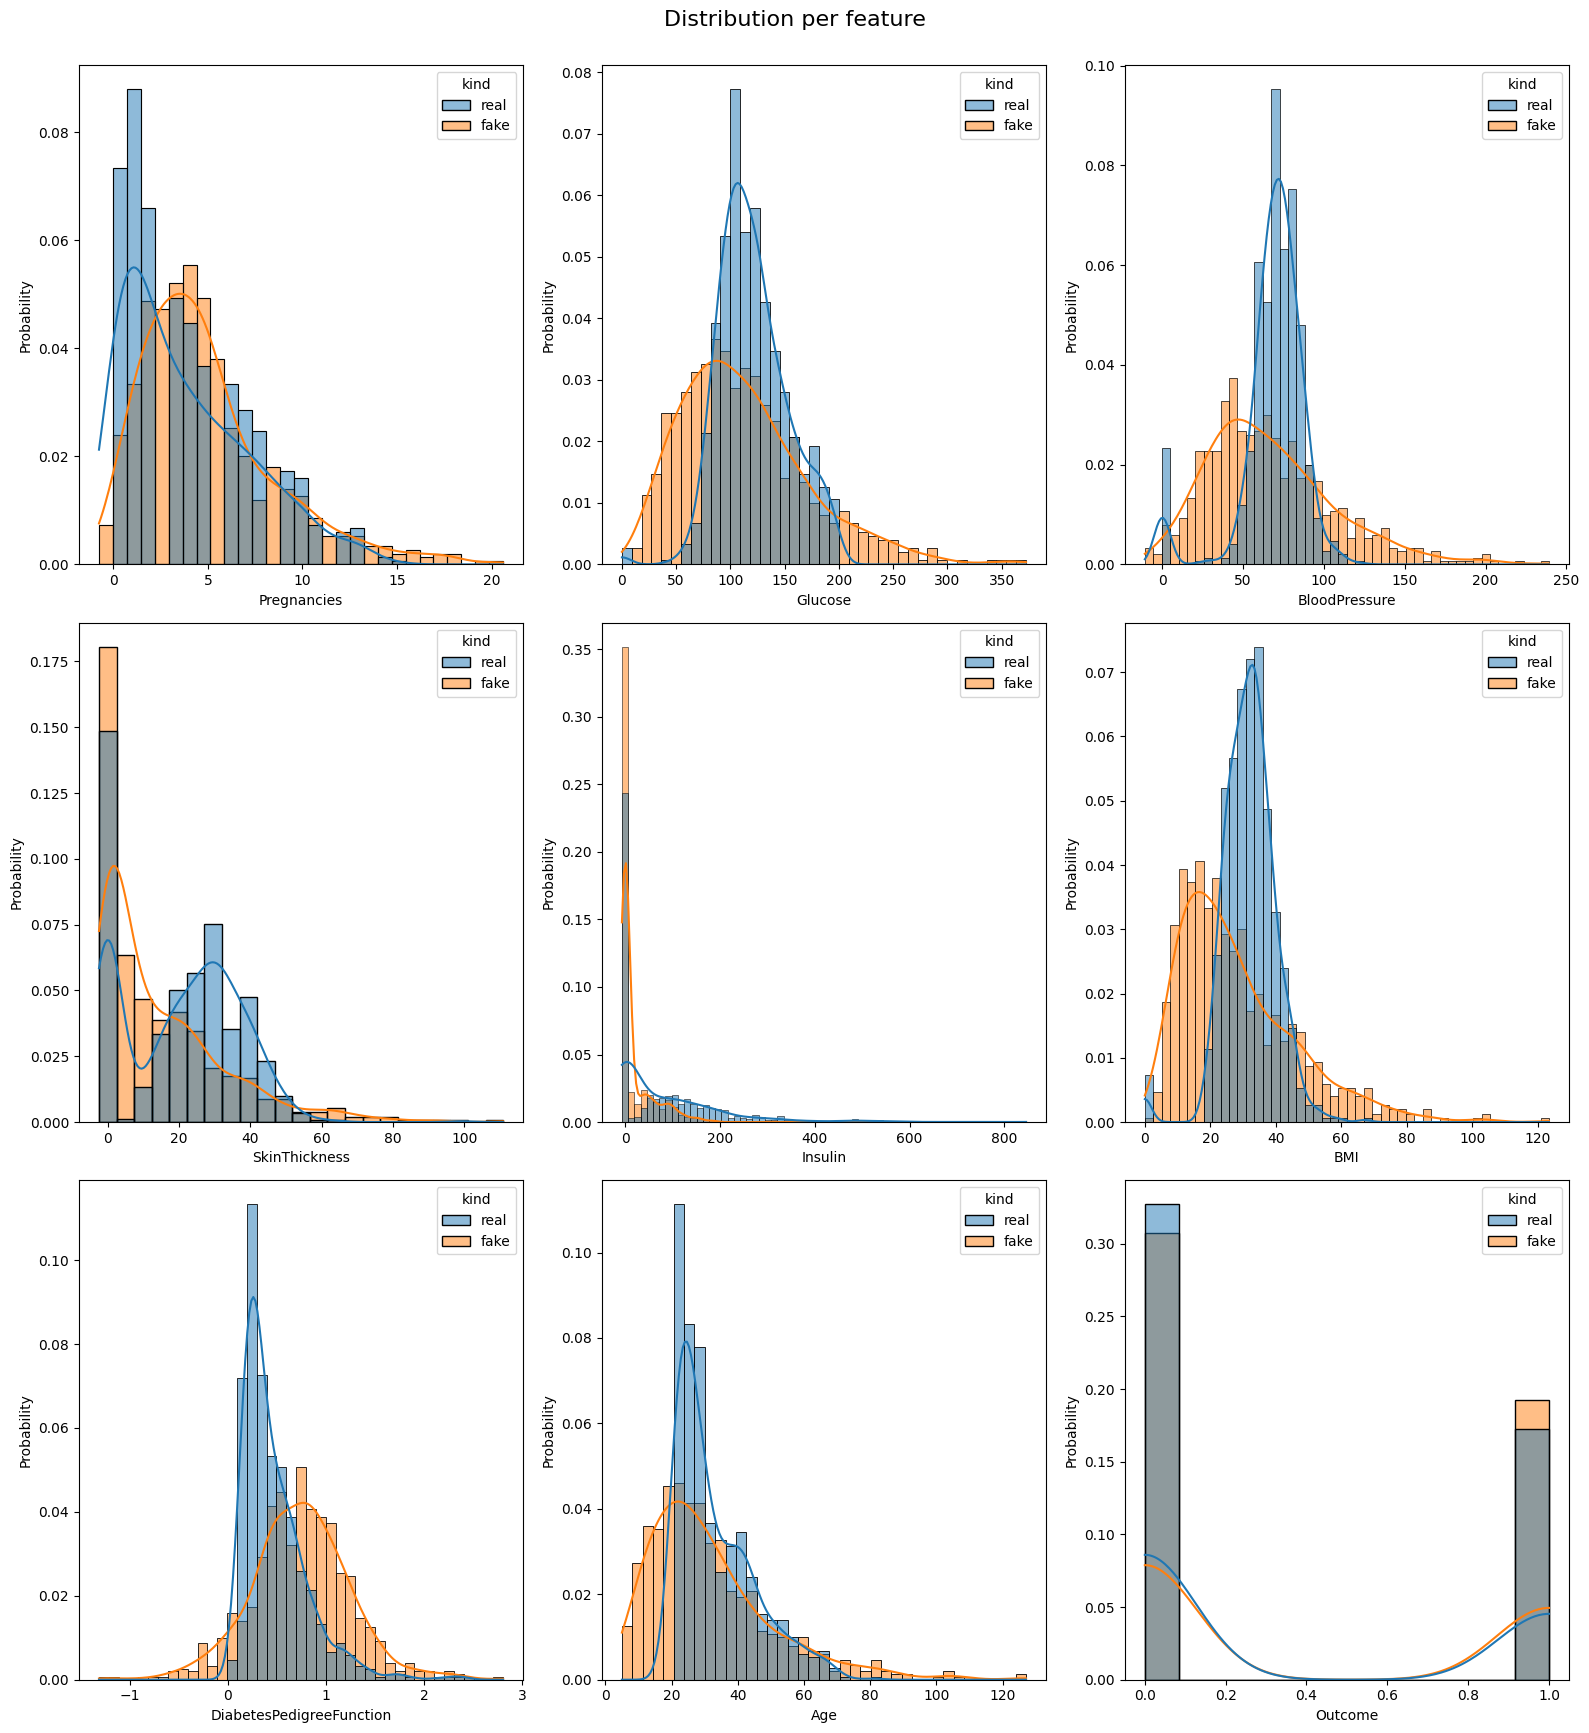

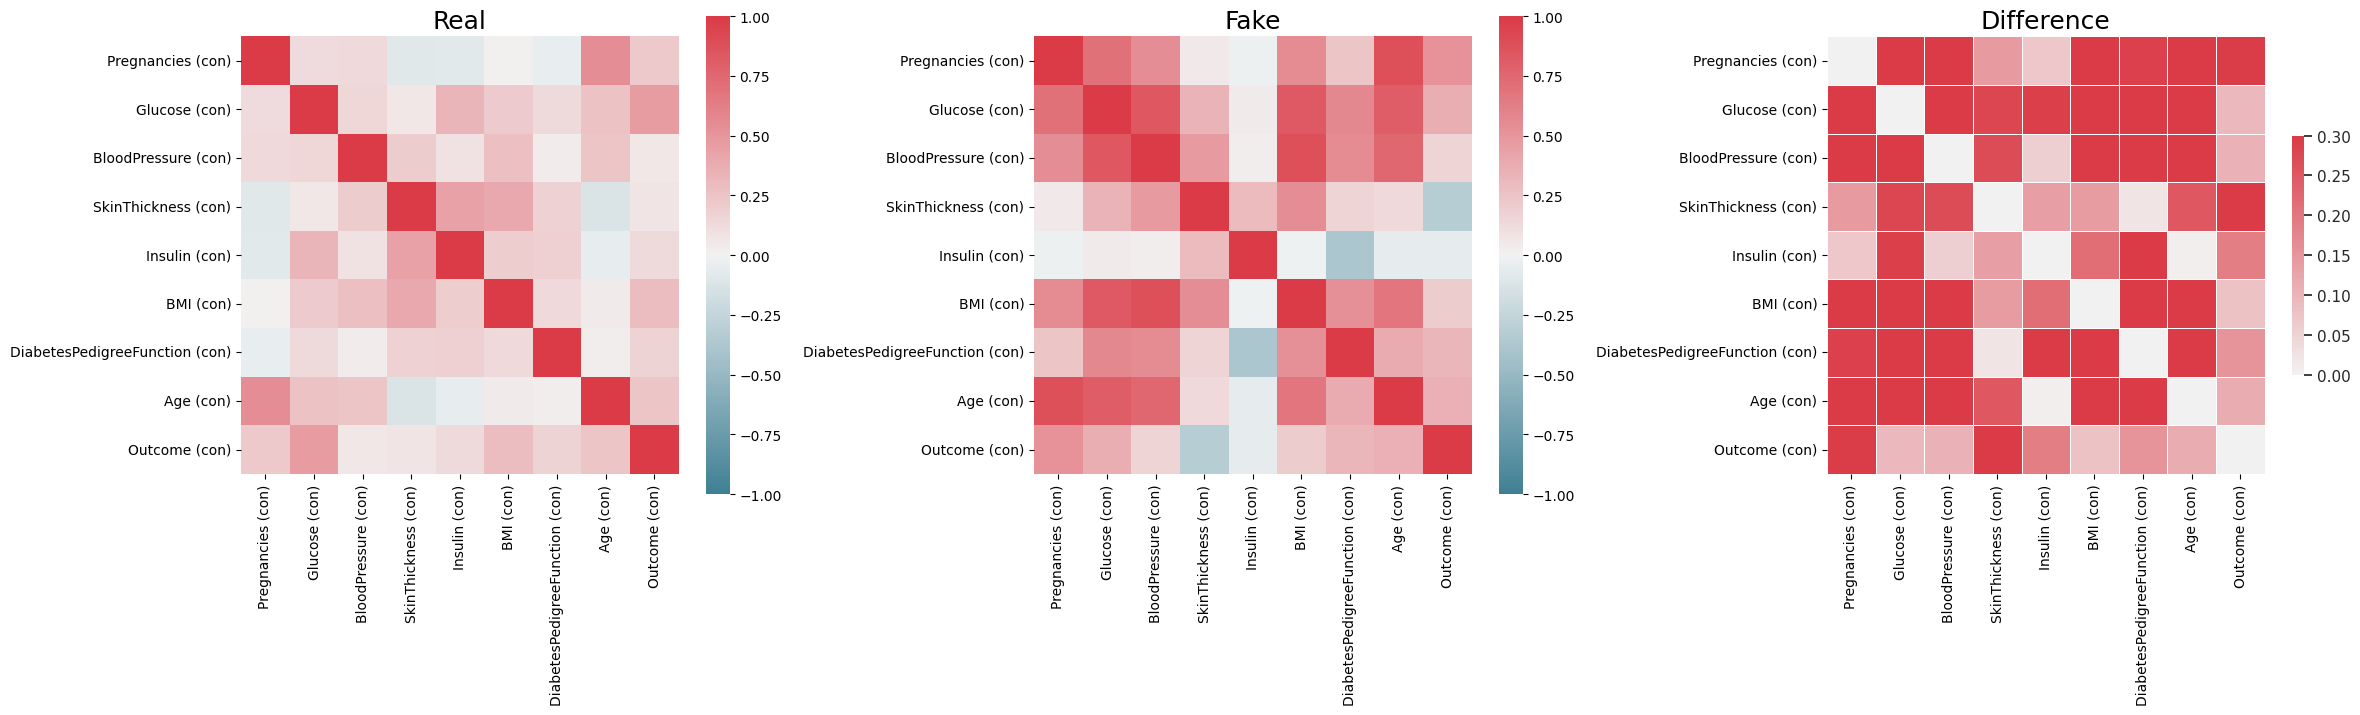

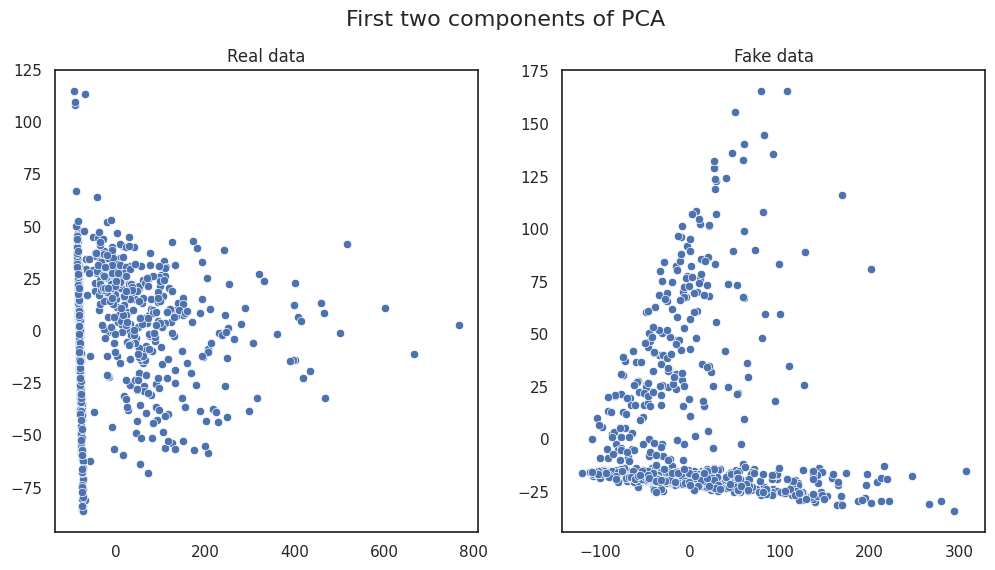

In [22]:
table_evaluator.visual_evaluation()
